In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import pandas as pd


In [4]:
image_path = "images/hack2.png"

In [5]:
def display_image(title, image):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2 or image.shape[2] == 1:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Reading image from path: images/hack2.png


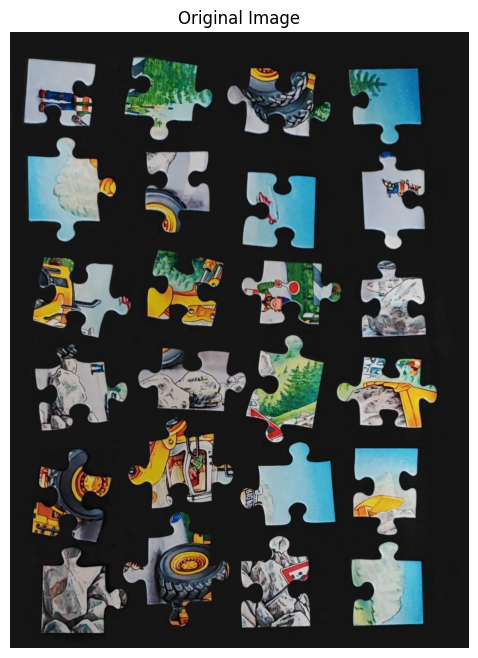

In [6]:
print("Reading image from path:", image_path)
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if original_image is None:
    raise ValueError(f"Could not read image from {image_path}")
display_image("Original Image", original_image)

Converting to grayscale


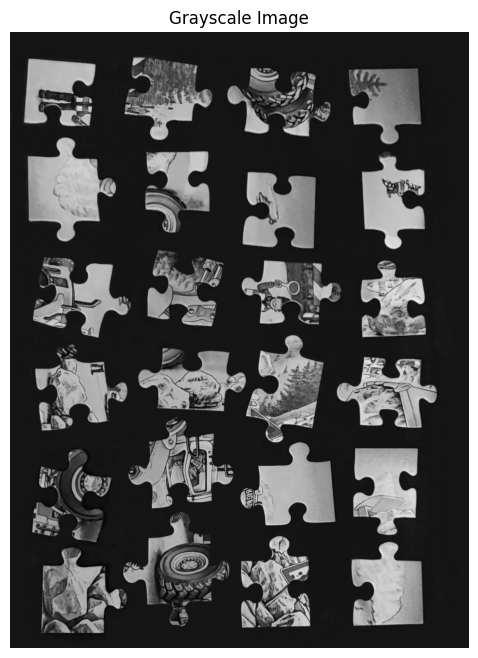

In [7]:
print("Converting to grayscale")
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
display_image("Grayscale Image", gray_image)

Threshold to separate pieces from background


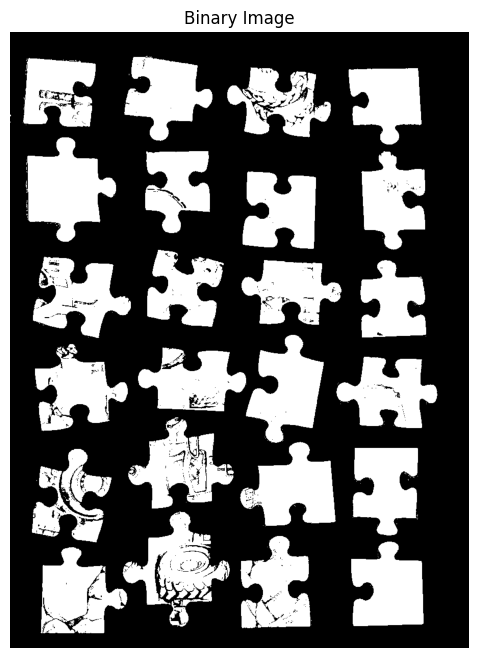

In [8]:
print("Threshold to separate pieces from background")
_, binary_image = cv2.threshold(gray_image, 30, 255, cv2.THRESH_BINARY)
display_image("Binary Image", binary_image)

In [9]:
print("Doing morph type operations")
kernel = np.ones((12, 12), np.uint8)

Doing morph type operations


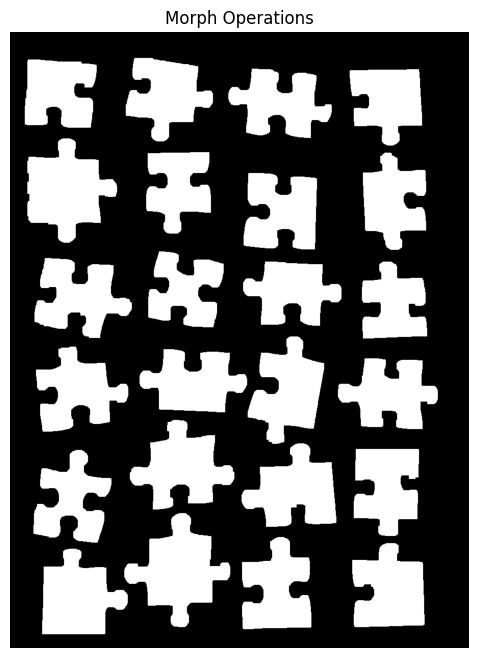

In [10]:
# Close = filling the holes
morph_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
# Open = removing the noise
morph_image = cv2.morphologyEx(morph_image, cv2.MORPH_OPEN, kernel)
display_image("Morph Operations", morph_image)

Filling holes in puzzle pieces


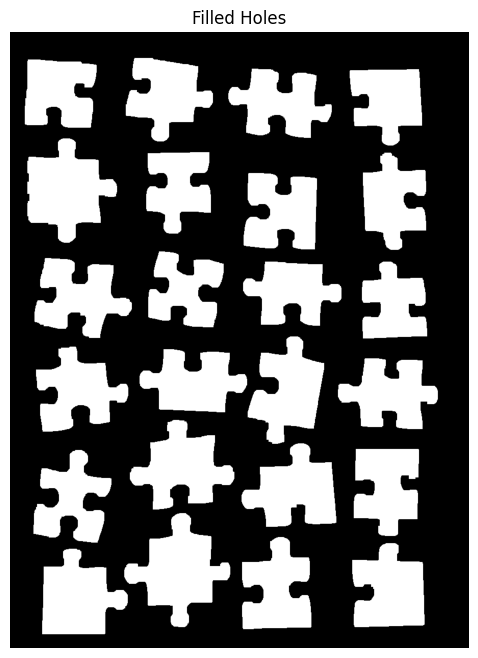

In [11]:
print("Filling holes in puzzle pieces")
contours_fill, _ = cv2.findContours(morph_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours_fill:
    cv2.drawContours(morph_image, [cnt], 0, 255, -1)
display_image("Filled Holes", morph_image)

In [12]:
print("Finding contours of pieces")
contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"Found {len(contours)} potential puzzle pieces")

Finding contours of pieces
Found 24 potential puzzle pieces


In [13]:
print("Filtering contours by size")
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
if len(contours) > 1:
    reference_area = cv2.contourArea(contours[1])
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > reference_area / 3]
print(f"After filtering: {len(contours)} puzzle pieces")

Filtering contours by size
After filtering: 24 puzzle pieces


Drawing contours of the original image


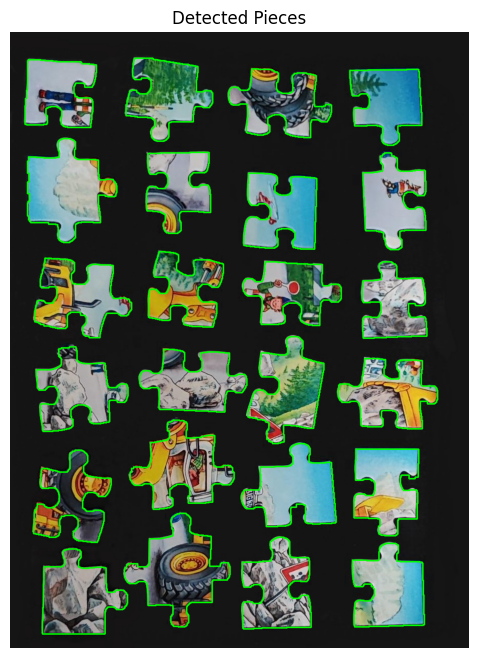

In [14]:
print("Drawing contours of the original image")
contour_image = original_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
display_image("Detected Pieces", contour_image)

In [15]:
output_folder_pieces = "images/extracted_pieces"
os.makedirs(output_folder_pieces, exist_ok=True)

output_folder_contours = "images/extracted_contours"
os.makedirs(output_folder_contours, exist_ok=True)

output_corner_folder = "images/extracted_corners"
os.makedirs(output_corner_folder, exist_ok=True)

output_plots_folder = "images/corner_plots"
os.makedirs(output_plots_folder, exist_ok=True)

In [16]:
piece_images = []
for i, contour in enumerate(contours):
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], 0, 255, -1)

    piece = np.zeros_like(original_image)
    piece[mask == 255] = original_image[mask == 255]

    x, y, w, h = cv2.boundingRect(contour)
    cropped_piece = piece[y:y + h, x:x + w]
    piece_images.append(cropped_piece)

    piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
    cv2.imwrite(piece_path, cropped_piece)

    # Save piece with contour
    contour_piece = cropped_piece.copy()
    mask_cropped = mask[y:y + h, x:x + w]
    cv2.drawContours(contour_piece, [contour - [x, y]], 0, (255, 0, 255), 1,
                     cv2.LINE_8)  # Pink, width 1, no anti-aliasing
    contour_path = os.path.join(output_folder_contours, f"contour_{i + 1}.png")
    cv2.imwrite(contour_path, contour_piece)

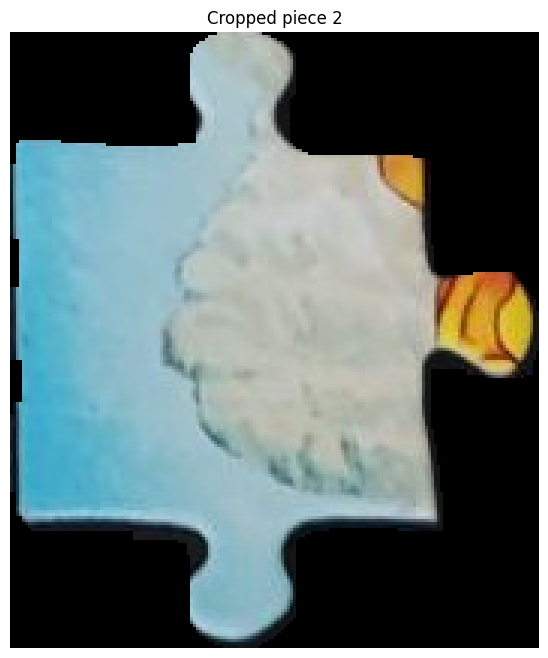

In [17]:
piece_images = []

i = 1
contour = contours[i]


# 1 ) get the pieces contour

mask = np.zeros_like(gray_image)
cv2.drawContours(mask, [contour], 0, 255, -1)

piece = np.zeros_like(original_image)
piece[mask == 255] = original_image[mask == 255]
x, y, w, h = cv2.boundingRect(contour)
cropped_piece = piece[y:y + h, x:x + w]
piece_images.append(cropped_piece)

piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
cv2.imwrite(piece_path, cropped_piece)
contour_piece = cropped_piece.copy()

display_image(f"Cropped piece {i+1}", contour_piece)


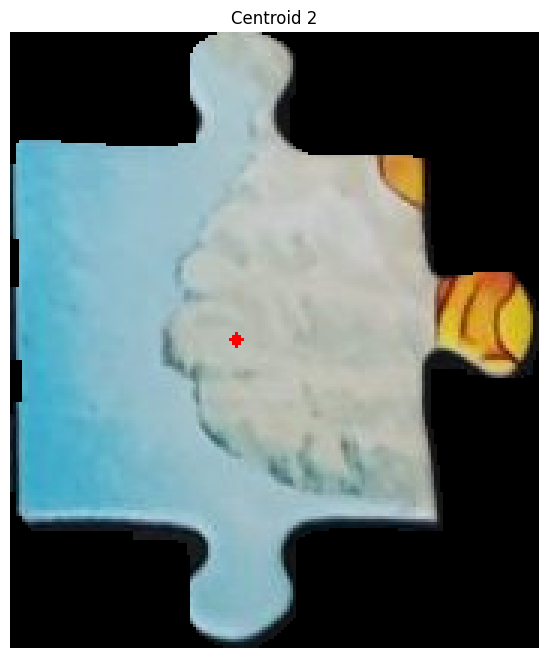

In [18]:
# 2)  get each contour center
M = cv2.moments(contour)

if M["m00"] == 0:
    print("ERROR")
centroid_x = int(M["m10"] / M["m00"])
centroid_y = int(M["m01"] / M["m00"])
cv2.circle(contour_piece, (centroid_x - x, centroid_y - y), 2, (0, 0, 255), -1)
display_image(f"Centroid {i+1}", contour_piece)

In [19]:
def rainbow_color(t):
    t = t % 256  # wrap around after 255
    phase = t / 256 * 6
    x = int(255 * (1 - abs(phase % 2 - 1)))
    if phase < 1:     return (255, x, 0)       # Red → Yellow
    elif phase < 2:   return (x, 255, 0)       # Yellow → Green
    elif phase < 3:   return (0, 255, x)       # Green → Cyan
    elif phase < 4:   return (0, x, 255)       # Cyan → Blue
    elif phase < 5:   return (x, 0, 255)       # Blue → Magenta
    else:             return (255, 0, x)

In [20]:
# rainbow_piece = contour_piece.copy()
#
# print(x, y)
#
# contour_points = contour - np.array([x, y])
# counter = 0
# for point in contour:
#
#     px, py = point[0]
#     rainbow_piece[py - y, px -  x] = (rainbow_color(counter))
#     counter += 1
#
# display_image(f"Rainbow Contour {i+1}", rainbow_piece)


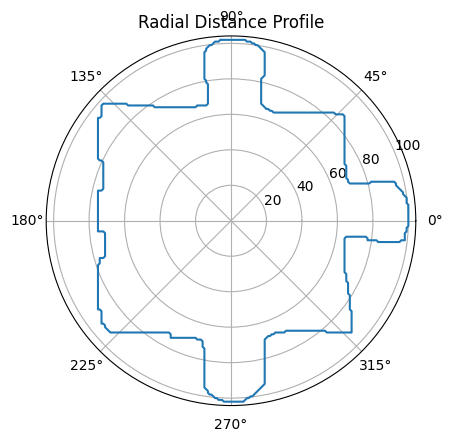

In [21]:
contour_points = contour - np.array([x, y])
distances = []
angles = []
for point in contour:
    px, py = point[0]
    dx = px - centroid_x
    dy = py - centroid_y
    distance = np.sqrt(dx ** 2 + dy ** 2)
    angle = np.arctan2(dy, dx)
    distances.append(distance)
    angles.append(angle)

angles_deg = np.array([(a * 180 / np.pi) % 360 for a in angles])

plt.polar(-np.array(angles), distances)
plt.title("Radial Distance Profile")
plt.show()

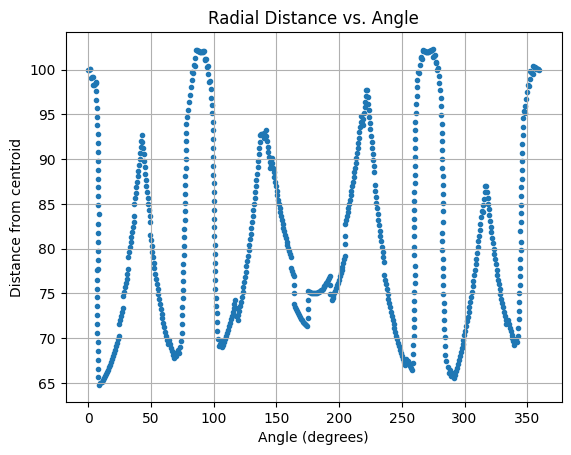

In [22]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle")
plt.grid(True)
plt.show()

In [89]:
min_distance_between_peaks = len(distances) // 10
print(min_distance_between_peaks, len(distances))
all_peak_indices, all_peak_properties = find_peaks(distances,                                 distance=min_distance_between_peaks,prominence=0.1)
print(all_peak_indices)

peak_angles = [angles_deg[peak_idx] for peak_idx in all_peak_indices]
peak_distances = [distances[peak_idx] for peak_idx in all_peak_indices]

71 712
[  3  99 232 341 427 535 611 698]


In [84]:
df = pd.DataFrame({
    'Index': all_peak_indices,         # Peak indices
    'Angle (degrees)': peak_angles,    # Peak angles
    'Distance': peak_distances         # Peak distances
})

df

,Index,Angle (degrees),Distance
0,3,264.907885,101.400197
1,99,221.682219,97.744565
2,232,141.532137,93.236259
3,341,86.074092,102.239914
4,427,42.814199,92.698436
5,535,354.857235,100.404183
6,611,317.327815,87.045965
7,698,274.484606,102.313244


In [91]:
max_angle_diff = 25
delCounter = 0

# Make copies as lists (so we can modify them)
remaining_peak_indices = all_peak_indices.tolist() if isinstance(all_peak_indices, np.ndarray) else all_peak_indices.copy()
remaining_peak_angles = peak_angles.tolist() if isinstance(peak_angles, np.ndarray) else peak_angles.copy()
remaining_peak_distances = peak_distances.tolist() if isinstance(peak_distances, np.ndarray) else peak_distances.copy()

# Continue until no more removals are needed
while True:
    removals_made = False

    # Check each adjacent pair
    for k in range(len(remaining_peak_angles)):
        if len(remaining_peak_angles) <= 1:
            break

        next_k = (k + 1) % len(remaining_peak_angles)  # Wrap-around logic

        # If the angle difference between consecutive elements is smaller than max_angle_diff
        if abs(remaining_peak_angles[next_k] - remaining_peak_angles[k]) < max_angle_diff:
            delCounter += 1
            removals_made = True

            # Determine which one to remove based on distance
            if remaining_peak_distances[k] < remaining_peak_distances[next_k]:
                # Remove current index (k)
                remaining_peak_indices.pop(k)
                remaining_peak_angles.pop(k)
                remaining_peak_distances.pop(k)
            else:
                # Remove next index (next_k)
                remaining_peak_indices.pop(next_k)
                remaining_peak_angles.pop(next_k)
                remaining_peak_distances.pop(next_k)

            # After deletion, break from the inner loop to restart checking from the beginning
            break

    # If no removals were made in this pass, we're done
    if not removals_made or len(remaining_peak_angles) <= 1:
        break

# Convert back to numpy arrays if needed
all_peak_indices = np.array(remaining_peak_indices) if isinstance(all_peak_indices, np.ndarray) else remaining_peak_indices
peak_angles = np.array(remaining_peak_angles) if isinstance(peak_angles, np.ndarray) else remaining_peak_angles
peak_distances = np.array(remaining_peak_distances) if isinstance(peak_distances, np.ndarray) else remaining_peak_distances

# Print out the result
print(f"We deleted {delCounter} extra peak angles")

We deleted 1 extra peak angles


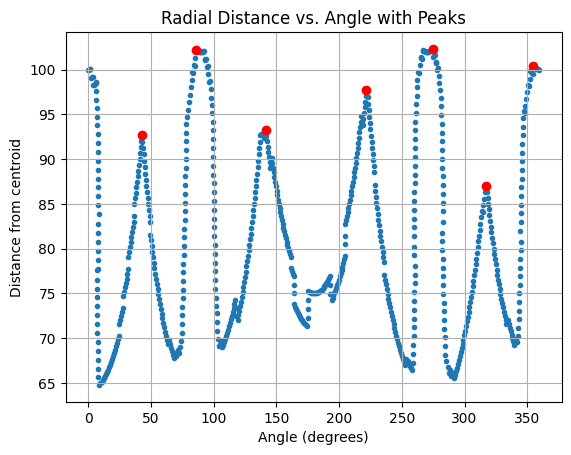

In [92]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='Peaks')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Peaks")
plt.grid(True)
plt.show()

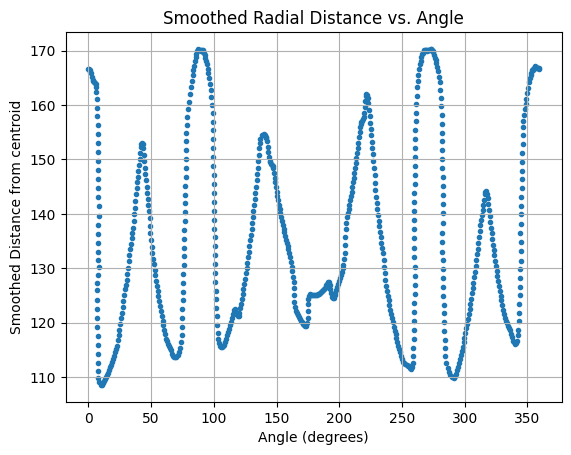

In [42]:
smoothed = [(
    distances[i-2] +
    distances[i-1] +
    distances[i] +
    distances[(i+1) % len(distances)] +
    distances[(i+2) % len(distances)]
            ) / 3
    for i in range(len(distances))
]

plt.style.use('default')
plt.scatter(angles_deg, smoothed, marker='.')
plt.xlabel("Angle (degrees)")
plt.ylabel("Smoothed Distance from centroid")
plt.title("Smoothed Radial Distance vs. Angle")
plt.grid(True)
plt.show()

71 712
[ 99 234 339 427 533 611]
[np.float64(221.68221883166515), np.float64(140.27389595735178), np.float64(87.19362974821175), np.float64(42.81419919322441), np.float64(355.9958270592906), np.float64(317.32781508904117)]
[np.float64(161.9547299893596), np.float64(154.60421751432713), np.float64(170.22040565469877), np.float64(153.09332245819064), np.float64(167.09104456105769), np.float64(144.13295009355153)]


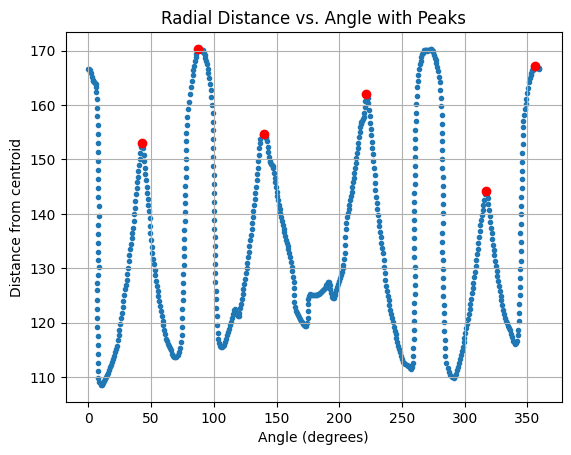

In [51]:
min_distance_between_peaks = len(smoothed) // 10
print(min_distance_between_peaks, len(smoothed))
all_peak_indices, all_peak_properties = find_peaks(smoothed,                                 distance=min_distance_between_peaks,prominence=2)
print(all_peak_indices)

peak_angles = [angles_deg[peak_idx] for peak_idx in all_peak_indices]
peak_distances = [smoothed[peak_idx] for peak_idx in all_peak_indices]

print(peak_angles)
print(peak_distances)

plt.style.use('default')
plt.scatter(angles_deg, smoothed, marker='.')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='Peaks')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Peaks")
plt.grid(True)
plt.show()